<a href="https://colab.research.google.com/github/Mr-Wonderfool/TJ_MCM/blob/master/LSTM%2BTCN_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Conv1D, Flatten, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!pip install keras-tcn
from tcn import TCN
from google.colab import drive
drive.mount('/content/drive')
from scipy.io import loadmat

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. 数据加载和预处理

In [ ]:
# 加载数据
data = pd.read_csv('/content/drive/MyDrive/train_2005to2019.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])

# 提取特定公司的股价数据
def company_data(company, start_time, end_time):
    specific_data = data[['Date', company]]
    return specific_data[(specific_data['Date'] > start_time) & (specific_data['Date'] < end_time)]

# 数据预处理：标准化和序列化
def data_processing(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# 提取和处理数据
company = 'AIR'
start_time = dt.datetime(2009,1,1)
end_time = dt.datetime(2019,1,1)
company_stock_price = company_data(company, start_time, end_time)
price = np.array(company_stock_price[company]).reshape(-1,1)

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(price)
seq_length = 100
X, y = data_processing(normalized_data, seq_length)

# 分割数据集
split = int(len(normalized_data) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

3. 构建并训练CNN和TCN并行模型

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 定义模型
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_branch = LSTM(units=100, return_sequences=True)(input_layer)
lstm_branch = Dropout(0.8)(lstm_branch)
lstm_branch = LSTM(units=80, return_sequences=True)(lstm_branch)
lstm_branch = Dropout(0.8)(lstm_branch)
lstm_branch = LSTM(units=60, return_sequences=False)(lstm_branch)
tcn_branch = TCN(nb_filters=64, kernel_size=6, dilations=[1, 2, 4, 8], return_sequences=False)(input_layer)
merged = concatenate([lstm_branch, tcn_branch])
hidden_layer = Dense(units=256, activation='relu')(merged)
output_layer = Dense(units=1)(hidden_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

# 模型摘要
model.summary()

# 回调函数
checkpoints = ModelCheckpoint(filepath='/content/drive/MyDrive/LSTM_TCN_AIR_weights.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# 模型训练
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32, callbacks=[checkpoints, early_stopping, reduce_lr])



Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 100, 1)]             0         []                            
                                                                                                  
 lstm_48 (LSTM)              (None, 100, 100)             40800     ['input_17[0][0]']            
                                                                                                  
 dropout_32 (Dropout)        (None, 100, 100)             0         ['lstm_48[0][0]']             
                                                                                                  
 lstm_49 (LSTM)              (None, 100, 80)              57920     ['dropout_32[0][0]']          
                                                                                           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 1s 17ms/step - loss: 7.8680e-04 - val_loss: 0.0034 - lr: 0.0010
Epoch 3/25
63/63 [==============================] - 1s 18ms/step - loss: 8.4920e-04 - val_loss: 8.3765e-04 - lr: 0.0010
Epoch 4/25
63/63 [==============================] - 1s 18ms/step - loss: 6.2465e-04 - val_loss: 8.0299e-04 - lr: 0.0010
Epoch 5/25
63/63 [==============================] - 1s 17ms/step - loss: 5.5459e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 6/25
63/63 [==============================] - 1s 17ms/step - loss: 6.2728e-04 - val_loss: 0.0080 - lr: 0.0010
Epoch 7/25
63/63 [==============================] - 1s 17ms/step - loss: 4.1465e-04 - val_loss: 9.9073e-04 - lr: 2.0000e-04
Epoch 8/25
63/63 [==============================] - 1s 17ms/step - loss: 2.9469e-04 - val_loss: 8.3741e-04 - lr: 2.0000e-04
Epoch 9/25
63/63 [==============================] - 1s 20ms/step - loss: 3.0837e-04 - val_loss: 6.4902e-04 - lr: 2.0000e-04
Epoch 10/25
63/63 [==============================] 

4. 模型评估和结果可视化

13/13 [==============================] - 0s 7ms/step
2012
404
Train MAE: 0.4699980425787255
Test MAE: 0.7249843011988276


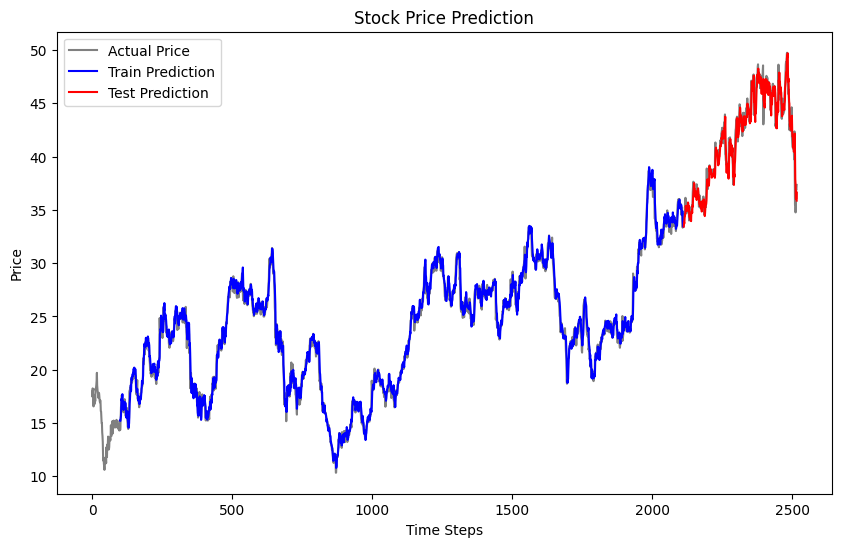

In [ ]:
import matplotlib.pyplot as plt

# 预测并逆归一化
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# 逆归一化真实值
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
print(len(train_predict))
print(len(test_predict))
# 计算误差
train_error_mae = mean_absolute_error(y_train_inv, train_predict)
test_error_mae = mean_absolute_error(y_test_inv, test_predict)
print('Train MAE:', train_error_mae)
print('Test MAE:', test_error_mae)

# 可视化预测结果
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(normalized_data), label='Actual Price', color='grey')  # 绘制整体实际价格
plt.plot(range(seq_length, seq_length + len(y_train)), train_predict, label='Train Prediction', color='blue')  # 绘制训练集预测结果
plt.plot(range(seq_length + len(y_train), seq_length + len(y_train) + len(y_test)), test_predict, label='Test Prediction', color='red')  # 绘制测试集预测结果
plt.title('Stock Price Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()


5. 基于模型的交易策略

In [ ]:
# 简化的交易策略
capital = 10000  # 初始资金
shares = 0  # 持股数量
portfolio_value = capital

for i in range(1, len(test_predict)):
    predicted_change = test_predict[i] - test_predict[i-1]
    if predicted_change > 0 and shares == 0:
        shares = capital / scaler.inverse_transform(y_test[i].reshape(-1, 1))[0][0]
        capital = 0
    elif predicted_change < 0 and shares > 0:
        capital = shares * scaler.inverse_transform(y_test[i].reshape(-1, 1))[0][0]
        shares = 0

if shares > 0:
    capital += shares * scaler.inverse_transform(y_test[-1].reshape(-1, 1))[0][0]

final_portfolio_value = capital
return_rate = (final_portfolio_value - portfolio_value) / portfolio_value * 100
print(f"Final Portfolio Value: {final_portfolio_value}, Return Rate: {return_rate:.2f}%")


Final Portfolio Value: 8253.037599712457, Return Rate: -17.47%


In [ ]:
import numpy as np

# 初始资金和股票持有状态
capital = 10000  # 初始资金
shares = 0  # 持有股票数
initial_capital = capital  # 用于最后计算收益率

# 通过测试集进行交易
for i in range(len(test_predict)):
    predicted_price = test_predict[i]
    actual_price = y_test_inv[i]

    # 判断买入或卖出
    if predicted_price > actual_price and capital > 0:
        # 买入
        shares = capital / actual_price  # 使用所有可用资金买入
        capital = 0  # 资金投入股票
    elif predicted_price < actual_price and shares > 0:
        # 卖出
        capital = shares * actual_price  # 卖出所有股票
        shares = 0  # 清空股票持有

# 最后一天如果还持有股票，则全部卖出
if shares > 0:
    capital += shares * y_test_inv[-1]
    shares = 0

# 计算最终的收益率
final_capital = capital
return_rate = (final_capital - initial_capital) / initial_capital * 100
print(f"Final Portfolio Value: {final_capital}")
print(f"收益率: {return_rate}%")

Final Portfolio Value: [12013.55197759]
收益率: [20.13551978]%
